In [38]:
import pandas as pd 
import numpy as np 
from scipy import stats
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBClassifier 
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pylab as plt
from matplotlib import pyplot
import mlxtend
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [39]:
dataset = pd.read_csv("train_final.csv")
test_dataset = pd.read_csv("test_final.csv")

In [69]:
#feature_cols = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20','f21','f22','f23','f24']
feature_cols = ['f1','f3','f4','f7','f8','f10','f12','f13','f14','f15','f16','f17','f19','f23',]
# remove_feature_cols = ['f2','f5','f6','f9','f11','f18','f20','f21','f22','f24']
features_X = dataset[feature_cols]
target = 'Y'
IDcol = 'Id'
target_Y = dataset['Y']
test_feature = test_dataset[feature_cols]
test_Id = test_dataset['Id']
predictors = [x for x in features_X.columns if x not in [target,IDcol]]
# z = np.abs(stats.zscore(dataset))
# print(z)


In [41]:
param_test1 = {
    'max_depth':range(21,27,1),
    'min_child_weight':range(1,4,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( 
    learning_rate =0.1, 
    n_estimators=140, 
    max_depth=25,
    min_child_weight=1, 
    gamma=0.0, 
    subsample=0.85, 
    colsample_bytree=0.25,
    objective= 'binary:logistic', 
    nthread=16, 
    scale_pos_weight=1, 
    seed=42,
), 
param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=10)
gsearch1.fit(dataset[predictors],dataset['Y'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([14.21579709, 11.88407311,  9.34350173, 10.43644793,  9.14685814,
          8.76157098, 10.33822656,  9.57435386,  9.36220648, 10.85164146,
          9.6891798 ,  9.27398632, 11.11300008,  9.93753548,  8.55842521,
         10.24100401,  9.72608793,  7.4964864 ]),
  'std_fit_time': array([1.96425174, 2.09664001, 0.19053877, 0.18231844, 0.26126099,
         0.06310303, 0.17581757, 0.21818558, 0.17227321, 0.17066029,
         0.175779  , 0.15387541, 0.15700369, 0.17924537, 0.21577886,
         0.1807644 , 0.18579755, 1.04233319]),
  'mean_score_time': array([0.01940448, 0.01460371, 0.01120305, 0.01460378, 0.0118026 ,
         0.01270335, 0.01260316, 0.01600413, 0.01120284, 0.01200287,
         0.01340322, 0.01140261, 0.01260307, 0.01140292, 0.01050274,
         0.01250334, 0.01120305, 0.01040275]),
  'std_score_time': array([0.00979214, 0.00772429, 0.00107728, 0.00718764, 0.0007484 ,
         0.00619867, 0.00111344, 0.00640486, 0.00107732, 0.00063245,
         0.0

In [42]:
param_test2 = {
    'gamma':[i/10.0 for i in range(0,10)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( 
    learning_rate =0.1, 
    n_estimators=140, 
    max_depth=25,
    min_child_weight=1, 
    gamma=0.0, 
    subsample=0.85, 
    colsample_bytree=0.25,
    objective= 'binary:logistic', 
    nthread=16, 
    scale_pos_weight=1, 
    seed=42,
), 
param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=10)
gsearch1.fit(dataset[predictors],dataset['Y'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([9.56855254, 9.65257099, 9.71838639, 9.81470809, 9.87852294,
         9.84721587, 9.80470541, 9.81890898, 9.92343252, 7.23832822]),
  'std_fit_time': array([0.2532031 , 0.20401522, 0.21757479, 0.11823936, 0.15138068,
         0.14932322, 0.10830024, 0.14456433, 0.09301634, 3.12794177]),
  'mean_score_time': array([0.02070498, 0.0163043 , 0.02020514, 0.01200314, 0.01360328,
         0.01370292, 0.015904  , 0.01320343, 0.01770411, 0.01000233]),
  'std_score_time': array([0.01078217, 0.01391711, 0.0181908 , 0.00141458, 0.00590379,
         0.00490145, 0.0066862 , 0.00601437, 0.00827282, 0.00118345]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4},
   {'gamma'

In [44]:
param_test3 = {
    'subsample':[i/100.0 for i in range(80,84,1)],
    'colsample_bytree':[i/100.0 for i in range(23,28,1)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(
    learning_rate =0.1, 
    n_estimators=140, 
    max_depth=25,
    min_child_weight=1, 
    gamma=0.0, 
    subsample=0.85, 
    colsample_bytree=0.25,
    objective= 'binary:logistic', 
    nthread=16, 
    scale_pos_weight=1, 
    seed=42,
), 
param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=10)
gsearch1.fit(dataset[predictors],dataset['Y'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([11.99789762, 11.42426963,  8.90640357,  8.82898669,  8.82258463,
          9.34480269,  9.54194667,  9.35390437,  9.97964554,  9.81280777,
          9.77149835,  9.68968   ,  9.61606333,  9.66187351,  9.63336735,
          9.74509177,  9.60025942,  9.6723762 ,  9.72528787,  6.72931368]),
  'std_fit_time': array([1.37833108, 2.08093439, 0.19976338, 0.15417656, 0.13217586,
         0.17269992, 0.21458138, 0.18033882, 0.03946099, 0.23448331,
         0.10955811, 0.12225692, 0.08653055, 0.14446995, 0.15359474,
         0.10723998, 0.0683214 , 0.11078166, 0.10831174, 1.6211402 ]),
  'mean_score_time': array([0.01210303, 0.01810422, 0.01890512, 0.01190274, 0.0122031 ,
         0.01230297, 0.01180329, 0.0127033 , 0.01180282, 0.01360326,
         0.01340356, 0.011303  , 0.01190312, 0.01560373, 0.01140301,
         0.01210303, 0.0109026 , 0.01180284, 0.01360323, 0.01000233]),
  'std_score_time': array([0.00053846, 0.01347462, 0.01482584, 0.00094364, 0.00074852,
       

In [45]:
param_test4 = {
#     'reg_alpha':[1e-9, 1e-8, 1e-7,1e-6, 1e-5, 1e-4,1e-3,0.01,0.1,1,1.1]
    'reg_alpha':[ .1, .2,.3,.4,0]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( 
    learning_rate =0.1, 
    n_estimators=140, 
    max_depth=25,
    min_child_weight=1, 
    gamma=0.0, 
    subsample=0.81, 
    colsample_bytree=0.25,
    objective= 'binary:logistic', 
    nthread=16, 
    scale_pos_weight=1, 
    seed=42,
), 
param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=10)
gsearch1.fit(dataset[predictors],dataset['Y'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([9.58495629, 9.37380822, 9.15385959, 8.93763499, 8.16506078]),
  'std_fit_time': array([0.25176923, 0.42057464, 0.24686489, 0.20120948, 2.67009031]),
  'mean_score_time': array([0.01900425, 0.01830423, 0.02310536, 0.01750414, 0.01080263]),
  'std_score_time': array([0.00922168, 0.01159617, 0.01821104, 0.01192084, 0.00160041]),
  'param_reg_alpha': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0.1},
   {'reg_alpha': 0.2},
   {'reg_alpha': 0.3},
   {'reg_alpha': 0.4},
   {'reg_alpha': 0}],
  'split0_test_score': array([0.90228388, 0.89492773, 0.89415735, 0.89459367, 0.89430734]),
  'split1_test_score': array([0.87943142, 0.87474093, 0.87617262, 0.87959504, 0.8786474 ]),
  'split2_test_score': array([0.88526725, 0.88362422, 0.88322198, 0.88938506, 0.89633897]),
  'split3_test_score': array([0.91493046, 0.9128511 , 0.91971639, 0.914

In [52]:
param_test4 = {
#     'reg_alpha':[1e-9, 1e-8, 1e-7,1e-6, 1e-5, 1e-4,1e-3,0.01,0.1,1,1.1]
    'reg_lamda':[ 1,1.1,1.2,1.3]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( 
    learning_rate =0.1, 
    n_estimators=140, 
    max_depth=25,
    min_child_weight=1, 
    gamma=0.0, 
    subsample=0.81, 
    colsample_bytree=0.25,
    objective= 'binary:logistic', 
    nthread=16, 
    scale_pos_weight=1, 
    seed=42,
), 
param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=10)
gsearch1.fit(dataset[predictors],dataset['Y'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([13.10014606, 12.30746942,  9.50493841,  6.42664571]),
  'std_fit_time': array([1.47186448, 2.24425181, 0.20189599, 1.72429719]),
  'mean_score_time': array([0.01920447, 0.01430328, 0.0205049 , 0.01020241]),
  'std_score_time': array([0.00962303, 0.00611779, 0.0109502 , 0.00060026]),
  'param_reg_lamda': masked_array(data=[1, 1.1, 1.2, 1.3],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_lamda': 1},
   {'reg_lamda': 1.1},
   {'reg_lamda': 1.2},
   {'reg_lamda': 1.3}],
  'split0_test_score': array([0.89430734, 0.89430734, 0.89430734, 0.89430734]),
  'split1_test_score': array([0.8786474, 0.8786474, 0.8786474, 0.8786474]),
  'split2_test_score': array([0.89633897, 0.89633897, 0.89633897, 0.89633897]),
  'split3_test_score': array([0.92155031, 0.92155031, 0.92155031, 0.92155031]),
  'split4_test_score': array([0.91379193, 0.91379193, 0.91379193, 0.91379193]),
  'split5_test_score': array([

In [50]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=10, early_stopping_rounds=200):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Y'],eval_metric='auc')
    print("Model Fitted")
        

Model Fitted


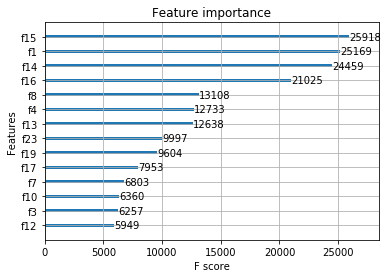

Beginning K-Fold
[0.90657211 0.8876477  0.88614384 0.92248057 0.90603646 0.91966971
 0.89724535 0.89575674 0.92070149 0.91677073]
0.9059024694692814
Accuracy: 90.59% (1.31%)


In [70]:
# X_train,X_test,y_train,y_test=train_test_split(features_X,target_Y,test_size=0.25,random_state=42)

# logreg = LogisticRegression()

# logreg.fit(X_train, y_train)

# y_pred = logreg.predict(X_test)

model = XGBClassifier(
    learning_rate =0.017, 
    n_estimators=10000, 
    max_depth=25,
    min_child_weight=1, 
    gamma=0.0, 
    subsample=0.81, 
    colsample_bytree=0.25,
    objective= 'binary:logistic', 
    nthread=16, 
    scale_pos_weight=1, 
    seed=42,
    reg_alpha = 0,
    reg_lambda = 1
)

# model_forest = RandomForestClassifier()
# model_forest.fit(predictors, target_Y)


modelfit(model,dataset,predictors)



plot_importance(model)
pyplot.show()
print("Beginning K-Fold")
kfold = KFold(n_splits=10, random_state=42)
results = cross_val_score(model, features_X, target_Y, cv=kfold, scoring='roc_auc')
print(results)
print(results.mean())
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [29]:

    #SUBMISSION #ALL FEATURES 
    learning_rate =0.017, 
    n_estimators=10000, 
    max_depth=25,
    min_child_weight=1, 
    gamma=0.0, 
    subsample=0.81, 
    colsample_bytree=0.25,
    objective= 'binary:logistic', 
    nthread=16, 
    scale_pos_weight=1, 
    seed=42,
    reg_alpha = 0,
    reg_lambda = 1
    
    0.9075962796964865
    Accuracy: 90.76% (1.48%)
        
    
    #PROVIDED LOWER KAGGLE SCORE 
    learning_rate =0.009, 
    n_estimators=5000, 
    max_depth=25,
    min_child_weight=1, 
    gamma=0.0, 
    subsample=0.85, 
    colsample_bytree=0.25,
    objective= 'binary:logistic', 
    nthread=16, 
    scale_pos_weight=1, 
    seed=42,
#     reg_alpha = .0002,
    reg_lambda = 0
    
    0.9093369616321241
    Accuracy: 90.93% (1.49%)
        
    

IndentationError: unexpected indent (<ipython-input-29-11995abb4f3c>, line 2)

In [66]:
print(results)
print(results.mean())
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0.90833972 0.88429866 0.88609988 0.92398835 0.91062303 0.92252566
 0.89662664 0.89799709 0.92248673 0.92297704]
0.9075962796964865
Accuracy: 90.76% (1.48%)


In [67]:
submitModelPredict = model.predict_proba(test_feature)
submission = pd.DataFrame({'Id': test_Id, 'Y':submitModelPredict[:,1]})
submission.head()

,Id,Y
0,16384,0.954620
1,16385,0.870210
2,16386,0.999335
3,16387,0.999284
4,16388,0.991040


In [68]:
filename = 'submit.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: submit.csv
